# Advanced usage

This notebook replicates what was done in the *simple_usage* notebooks, but this time with the advanced API. The advanced API is required if we want to use non-standard affinity methods that better preserve global structure.

If you are comfortable with the advanced API, please refer to the *preserving_global_structure* notebook for a guide how obtain better embeddings and preserve more global structure.

In [1]:
from openTSNE import TSNEEmbedding
from openTSNE.affinity import PerplexityBasedNN
from openTSNE import initialization
from openTSNE.callbacks import ErrorLogger

from examples import utils

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Load data

In [2]:
import gzip
import pickle

with gzip.open("data/macosko_2015.pkl.gz", "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"].astype(str)

In [3]:
print("Data set contains %d samples with %d features" % x.shape)

Data set contains 44808 samples with 50 features


## Create train/test split

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.33, random_state=42)

In [5]:
print("%d training samples" % x_train.shape[0])
print("%d test samples" % x_test.shape[0])

30021 training samples
14787 test samples


## Create a t-SNE embedding

Like in the *simple_usage* notebook, we will run the standard t-SNE optimization.

This example shows the standard t-SNE optimization. Much can be done in order to better preserve global structure and improve embedding quality. Please refer to the *preserving_global_structure* notebook for some examples.

**1. Compute the affinities between data points**

In [6]:
%%time
affinities_train = PerplexityBasedNN(
    x_train,
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
)

CPU times: user 27 s, sys: 291 ms, total: 27.3 s
Wall time: 14 s


**2. Generate initial coordinates for our embedding**

In [7]:
%time init_train = initialization.pca(x_train, random_state=42)

CPU times: user 330 ms, sys: 3.59 ms, total: 333 ms
Wall time: 57.6 ms


**3. Construct the `TSNEEmbedding` object**

In [8]:
embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    callbacks=ErrorLogger(),
)

**4. Optimize embedding**

1. Early exaggeration phase

In [9]:
%time embedding_train_1 = embedding_train.optimize(n_iter=250, exaggeration=12, momentum=0.5)

Iteration   50, KL divergence  5.7901, 50 iterations in 1.0475 sec
Iteration  100, KL divergence  5.2511, 50 iterations in 1.0043 sec
Iteration  150, KL divergence  5.1615, 50 iterations in 1.0565 sec
Iteration  200, KL divergence  5.1268, 50 iterations in 1.0170 sec
Iteration  250, KL divergence  5.1076, 50 iterations in 1.2683 sec
CPU times: user 40.9 s, sys: 56.9 ms, total: 40.9 s
Wall time: 5.44 s


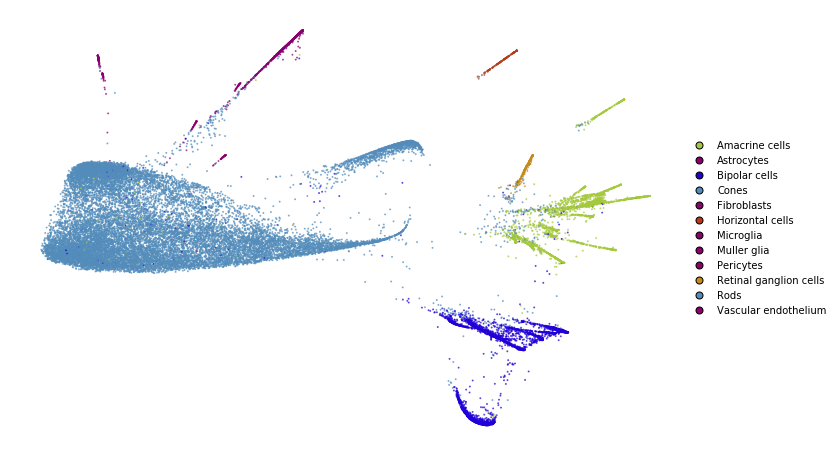

In [10]:
utils.plot(embedding_train_1, y_train, colors=utils.MACOSKO_COLORS)

2. Regular optimization

In [11]:
%time embedding_train_2 = embedding_train_1.optimize(n_iter=750, momentum=0.8)

Iteration   50, KL divergence  3.8025, 50 iterations in 1.0494 sec
Iteration  100, KL divergence  3.4117, 50 iterations in 1.5276 sec
Iteration  150, KL divergence  3.1974, 50 iterations in 1.2736 sec
Iteration  200, KL divergence  3.0556, 50 iterations in 1.5149 sec
Iteration  250, KL divergence  2.9535, 50 iterations in 1.8840 sec
Iteration  300, KL divergence  2.8751, 50 iterations in 2.0449 sec
Iteration  350, KL divergence  2.8137, 50 iterations in 2.5758 sec
Iteration  400, KL divergence  2.7644, 50 iterations in 3.6110 sec
Iteration  450, KL divergence  2.7245, 50 iterations in 3.3357 sec
Iteration  500, KL divergence  2.6918, 50 iterations in 3.8583 sec
Iteration  550, KL divergence  2.6652, 50 iterations in 5.1996 sec
Iteration  600, KL divergence  2.6436, 50 iterations in 4.6867 sec
Iteration  650, KL divergence  2.6260, 50 iterations in 5.3286 sec
Iteration  700, KL divergence  2.6112, 50 iterations in 6.6168 sec
Iteration  750, KL divergence  2.5991, 50 iterations in 7.2093

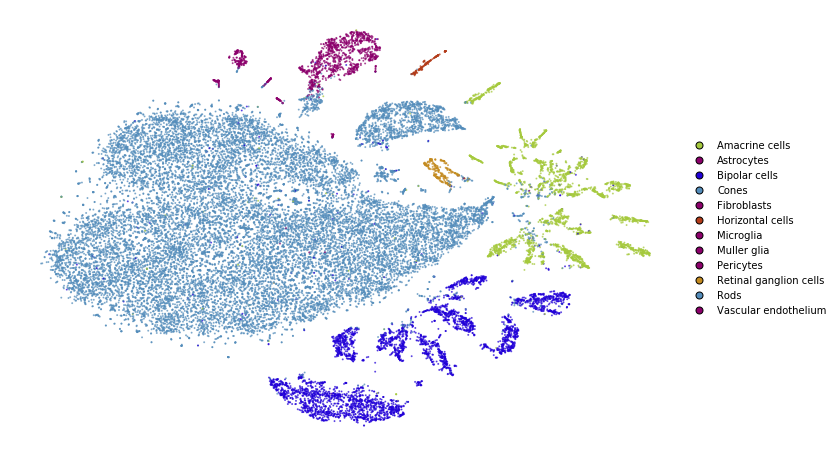

In [12]:
utils.plot(embedding_train_2, y_train, colors=utils.MACOSKO_COLORS)

## Transform

In [13]:
%%time
embedding_test = embedding_train_2.prepare_partial(
    x_test,
    initialization="median",
    k=25,
    perplexity=5,
)

CPU times: user 1.93 s, sys: 8 µs, total: 1.93 s
Wall time: 801 ms


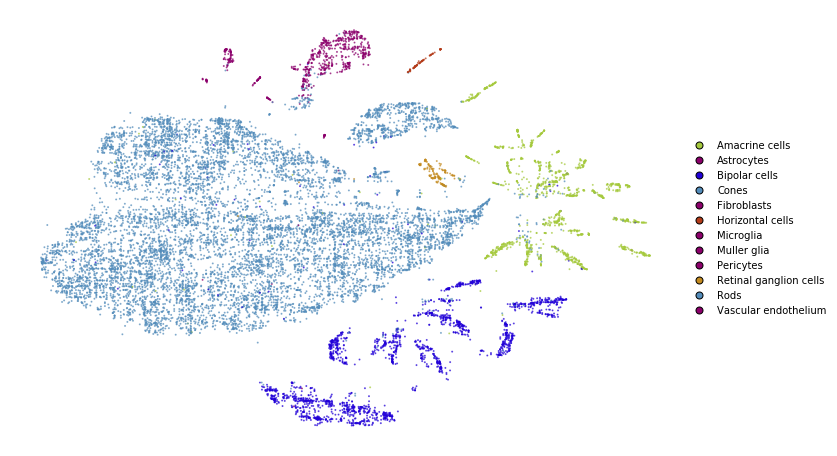

In [14]:
utils.plot(embedding_test, y_test, colors=utils.MACOSKO_COLORS)

In [15]:
%%time
embedding_test_1 = embedding_test.optimize(
    n_iter=100,
    learning_rate=1,
    exaggeration=2,
    momentum=0,
)

Iteration   50, KL divergence  212552.5028, 50 iterations in 6.6991 sec
Iteration  100, KL divergence  212498.8526, 50 iterations in 6.2299 sec
CPU times: user 1min 34s, sys: 89.6 ms, total: 1min 34s
Wall time: 13.1 s


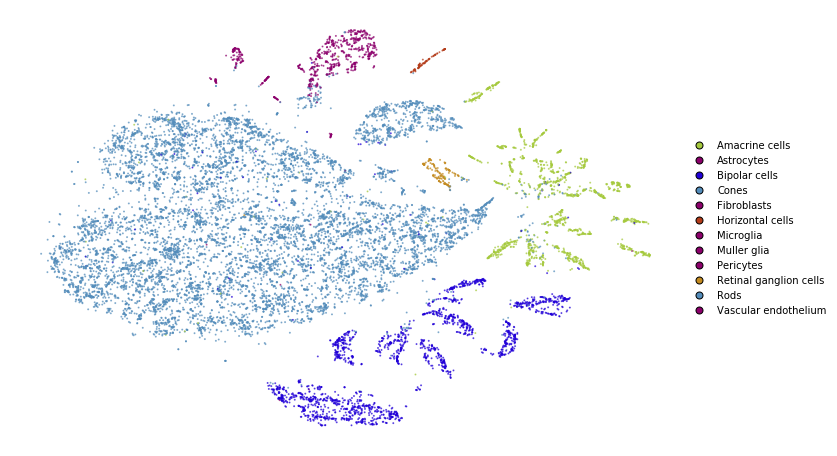

In [16]:
utils.plot(embedding_test_1, y_test, colors=utils.MACOSKO_COLORS)

## Together

We superimpose the transformed points onto the original embedding with larger opacity.

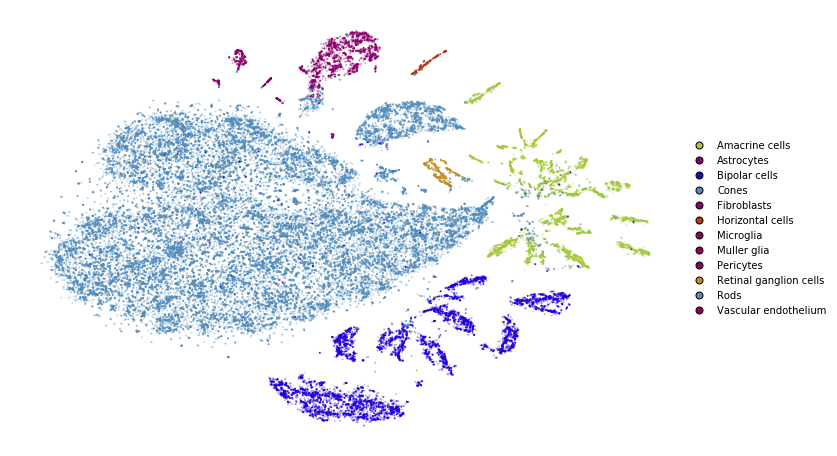

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
utils.plot(embedding_train_2, y_train, colors=utils.MACOSKO_COLORS, alpha=0.25, ax=ax)
utils.plot(embedding_test_1, y_test, colors=utils.MACOSKO_COLORS, alpha=0.75, ax=ax)